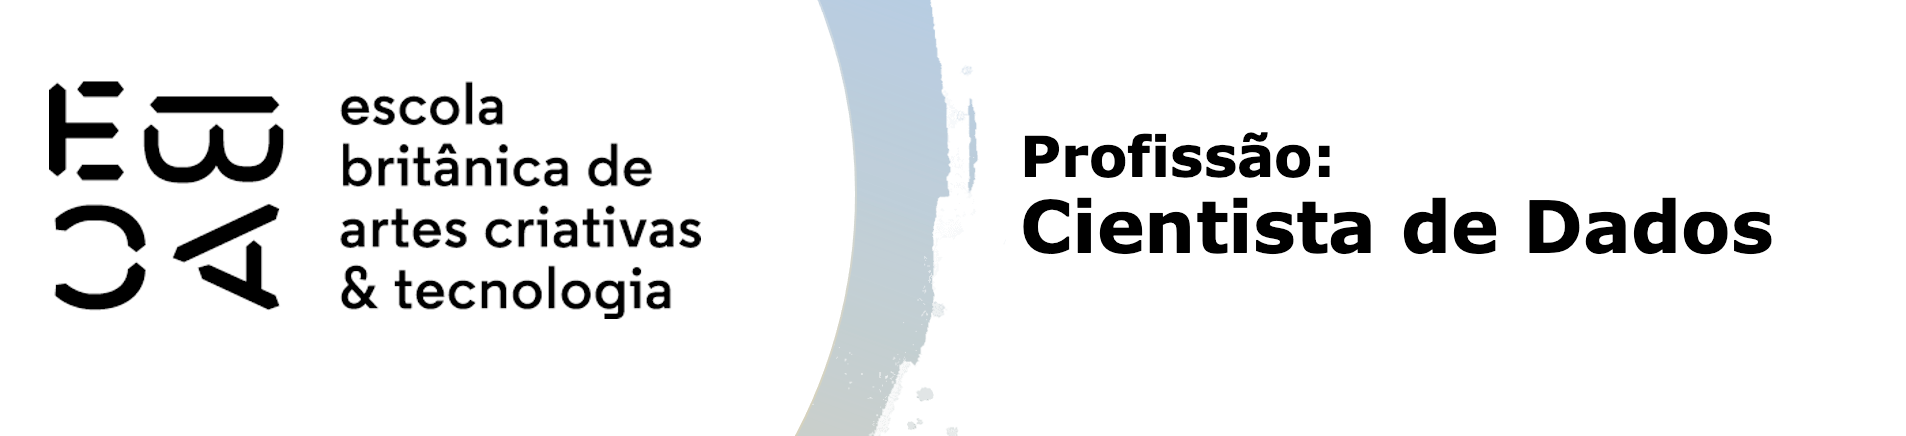

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
# Preencher NaN com a média do feature em questão
df.fillna({'tempo_emprego': df['tempo_emprego'].mean()}, inplace=True)
df['tempo_emprego'].isna().sum()

0

In [5]:
# Converter variáveis categóricas em variáveis dummy
df_dum = pd.get_dummies(df, drop_first=True, dtype=float)

In [6]:
# Dados de treino e teste
X = df_dum.drop('renda', axis=1)
y = df_dum['renda']

# Aplicar transformação log na variável renda
y_log = np.log(y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [7]:
# Converter X e y para tipos numéricos explícitos
X_train = X_train.astype(float)
y_train_log = y_train_log.astype(float)

# Adicionar uma constante para o intercepto
X_train_constant = sm.add_constant(X_train)

# Ajustar o modelo de regressão linear no conjunto de treino
model = sm.OLS(y_train_log, X_train_constant).fit()

# Avaliar o modelo usando o R^2 ajustado na base de treino
r2_ajustado = model.rsquared_adj
print("\nR^2 ajustado na base de treino:", r2_ajustado)

# Mostrar o resumo do modelo
print(model.summary())


R^2 ajustado na base de treino: 0.6879620027762821
                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                 3.392e+04
Date:                Mon, 22 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:04:35   Log-Likelihood:            -6.5193e+05
No. Observations:              600000   AIC:                         1.304e+06
Df Residuals:                  599960   BIC:                         1.304e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

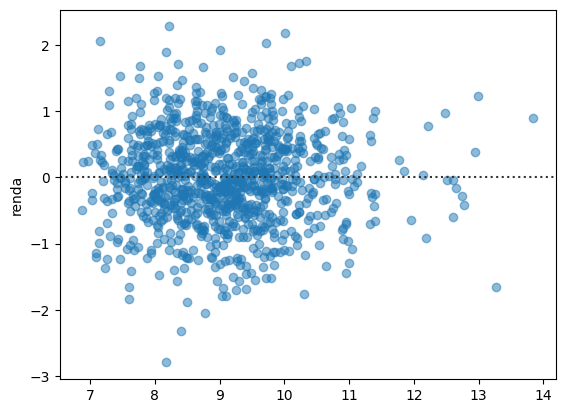

In [8]:
# Criar uma amostra do conjunto de dados de treino
sample_size = 1000  # Defina o tamanho da amostra
X_train_sample = X_train_constant.sample(n=sample_size, random_state=42)
y_train_sample = y_train_log.loc[X_train_sample.index]

# Plotar os resíduos na amostra da base de treino
sns.residplot(x=model.predict(X_train_sample), y=y_train_sample, lowess=False,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

In [9]:
# Obter resíduos
residuals = y_train_log - model.predict(X_train_constant)

In [12]:
# Calcular resíduos studentizados
st_res = model.get_influence().resid_studentized_internal

In [14]:
# Gráfico de resíduos studentizados vs valores preditos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.predict(X_train_constant), y=st_res, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.title('Resíduos Studentizados vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos Studentizados')
plt.show()

TypeError: 'module' object is not callable

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [ ]:
st_res = modelo.outlier_test()
sns.scatterplot(x = modelo.predict(), y = st_res.student_resid);

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.